In [1]:
# Dependencias Generales
import os
import gc
import nibabel as nib
import random
import numpy as np
import matplotlib.pyplot as plt
import time
import psutil

# Dependencias de PyTorch
import torch
import torch.nn as nn
from torch.utils.data import Dataset, random_split

# Dependencias de Fastai
from fastai.learner import Learner
from fastai.data.core import DataLoaders
from fastai.data.load import DataLoader
from fastai.vision.models import resnet34
from fastai.losses import L1LossFlat# MAE Loss for flatten (lineal)
from fastai.metrics import mae, BalancedAccuracy, accuracy
from fastai.test_utils import *
from fastai.vision.all import *

from sklearn.decomposition import PCA

In [2]:
# Fijar la semilla de PyTorch
torch.manual_seed(42)

# Fijar la semilla de NumPy
np.random.seed(42)

# Preprocesado

In [3]:
# Leer los dataFrames con las rutas y los datos
train = pd.read_csv('/kaggle/input/partition/trainAtlas.csv')
valid = pd.read_csv('/kaggle/input/partition/validAtlas.csv')
test = pd.read_csv('/kaggle/input/partition/testAtlas.csv')

### Normalizado de Datos

In [4]:
standard_normalize = lambda array: (array - np.mean(array)) / np.std(array) if np.std(array) != 0 else array - np.mean(array)

### Prueba de ocupación de memoria 

Probar traer 100 ejemplos para asi 

In [5]:
imgs = []
for i in range(0, 100):
    img_paths = train.iloc[i][['ruta_t1c', 'ruta_t1n', 'ruta_t2f', 'ruta_t2w']].tolist()
    slice_num = train.iloc[i]['slice']

    # Obtener las imágenes de cada prueba 
    X = np.zeros((240, 240, 4))
    for idx, img_path in enumerate(img_paths): # Combinar cada slice de las 4 pruebas en 4 canales
        current_img = nib.load(img_path).dataobj[..., slice_num]       
        X[:, :, idx] += standard_normalize(current_img)
    imgs.append(X)
    
# Obtener la cantidad total de memoria RAM en el sistema en bytes
total_ram = psutil.virtual_memory().total

# Obtener la cantidad de memoria RAM utilizada después de ejecutar el bucle en bytes
used_ram = psutil.virtual_memory().used

# Calcular el porcentaje de memoria RAM utilizada
percentage_used = (used_ram / total_ram) * 100

# Imprimir los resultados
print("Uso de memoria RAM después del bucle:", used_ram, "bytes")
print("Total de memoria RAM disponible:", total_ram, "bytes")
print("Porcentaje de memoria RAM utilizada:", percentage_used, "%")

del imgs

Uso de memoria RAM después del bucle: 1412362240 bytes
Total de memoria RAM disponible: 33669926912 bytes
Porcentaje de memoria RAM utilizada: 4.194729153084774 %


### Prueba de velocidad en el acceso de los datos

In [6]:
img_path = train.iloc[10000]['ruta_t1c']
inicio = time.time()
nib.load(img_path).dataobj[..., slice_num] 
fin = time.time()
print("Traer un único slice toma {:.4f} segundos".format(fin-inicio))


inicio = time.time()
nib.load(img_path).get_fdata()
fin = time.time()
print("Traer toda la resonancia toma {:.4f} segundos".format(fin-inicio))

Traer un único slice toma 0.0414 segundos
Traer toda la resonancia toma 0.2065 segundos


### PCA como prueba para la reducción de dimensionalidad

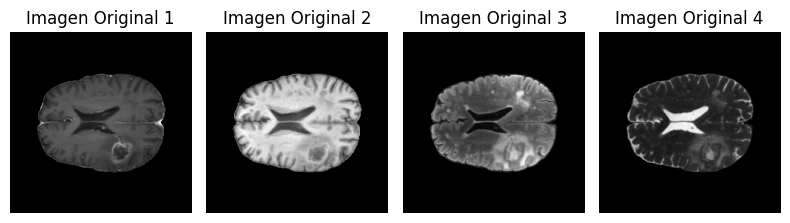

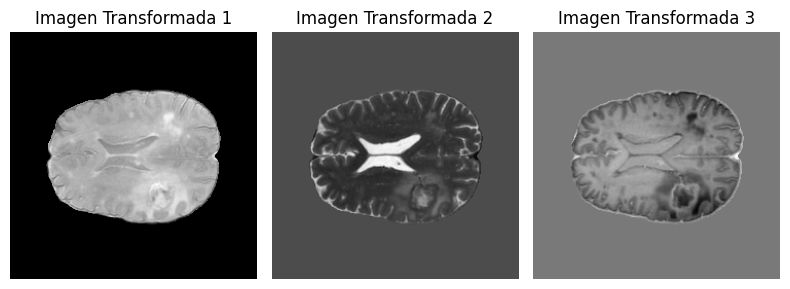

In [7]:
img_paths = train.iloc[10000][['ruta_t1c', 'ruta_t1n', 'ruta_t2f', 'ruta_t2w']].tolist()
slice_num = train.iloc[10000]['slice']

# Obtener las imágenes de cada prueba 
X = np.zeros((240, 240, 4))
for idx, img_path in enumerate(img_paths): # Combinar cada slice de las 4 pruebas en 4 canales
    current_img = nib.load(img_path).dataobj[..., slice_num]       
    X[:, :, idx] += standard_normalize(current_img)

# Aplicar una máscara para seleccionar solo los píxeles distintos de 0 (no negros)

stacked_data = X.reshape(-1, 4)
pca = PCA(n_components = 3)
transformed_data = pca.fit_transform(stacked_data)
X_f = transformed_data.reshape(240, 240, 3)

# Mostrar las imágenes originales y reconstruidas
fig, axs = plt.subplots(1, 4, figsize=(8, 4))

for i in range(4):
    axs[i].imshow(X[:, :, i], cmap='gray')
    axs[i].set_title(f'Imagen Original {i+1}')
    axs[i].axis('off')

plt.tight_layout()
plt.show()

fig, axs = plt.subplots(1, 3, figsize=(8, 4))
for i in range(3):
    axs[i].imshow(X_f[:, :, i], cmap='gray')
    axs[i].set_title(f'Imagen Transformada {i+1}')
    axs[i].axis('off')

plt.tight_layout()
plt.show()

In [8]:
stacked_data = X.reshape(-1, 4) 
pca = PCA()
transformed_data = pca.fit_transform(stacked_data)

# Varianza explicada por cada componente principal
explained_variance_ratio = pca.explained_variance_ratio_

# Imprimir la varianza explicada por cada componente principal
print("Varianza explicada por cada componente principal:", explained_variance_ratio)

# Identificar el componente principal con la menor varianza explicada
componente_menos_invariante = np.argmin(explained_variance_ratio)

# Imprimir el índice del componente principal menos invariante
print("Componente principal menos invariante:", componente_menos_invariante)

Varianza explicada por cada componente principal: [0.79523235 0.1484962  0.0499572  0.00631425]
Componente principal menos invariante: 3


In [ ]:
# Calcular la varianza de los píxeles para cada imagen
varianza_por_imagen = np.var(X[:, :, 0])
print(varianza_por_imagen)
# Identificar la imagen con menor varianza de píxeles
indice_imagen_menos_variante = np.argmin(varianza_por_imagen)

In [ ]:
from scipy.stats import entropy
# Calcular el histograma de la imagen
hist, _ = np.histogram(X[:, :, 0], bins=256, range=(0, 255))
    
# Normalizar el histograma para obtener una distribución de probabilidades
hist_prob = hist / np.sum(hist)
    
# Calcular la entropía de la distribución de probabilidades
entropia = entropy(hist_prob)
print(entropia)

### Preparación del encoder.

In [ ]:
class BraTS(Dataset):
  """
    Permite la lectura de los datos y etiquetas.
    Combina ambos para formar un tensor el cual va a ser pasado a un dataloader.
  """
  def __init__(self, atlas, transform=None):
    """
      Constructor de la clase dataset.

      Args:
      atlas (DataFrame): Frame de datos que contiene las rutas a cada ejemplo, el nº de slice y su etiqueta.
      transform (bool, optional): Aplicar transformaciones a las imágenes. Por defecto, no.

    """
    super(BraTS, self).__init__()
    self.atlas = atlas
    self.transform = transform
    self.mri_dtype = torch.float32

  def __len__(self):
    """
      Devuelve el tamaño del dataset
    """
    return len(self.atlas)

  def __getitem__(self, index):

    """
     Devuelve un elemento del dataset

    """
    
    # Obtener los paths de cada imagen
    img_paths = self.atlas.iloc[index][['ruta_t1c', 'ruta_t1n', 'ruta_t2f']].tolist()
    slice_num = self.atlas.iloc[index]['slice']

    # Obtener las imágenes de cada prueba 
    X = np.zeros((240, 240, 3))
    for idx, img_path in enumerate(img_paths): # Combinar cada slice de las 4 pruebas en 4 canales
      current_img = nib.load(img_path).dataobj[..., slice_num]       
      X[:, :, idx] += standard_normalize(current_img)
        
    x = torch.from_numpy(X.T).type(self.mri_dtype)
    y = torch.from_numpy(X.T).type(self.mri_dtype)
    
    del current_img
    del X

    return x, y

In [ ]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ConvBlock, self).__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.block(x)

class DownConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DownConv, self).__init__()
        self.sequence = nn.Sequential(
            ConvBlock(in_channels, out_channels),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

    def forward(self, x):
        return self.sequence(x)

class UpConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UpConv, self).__init__()
        self.sequence = nn.Sequential(
            nn.ConvTranspose2d(in_channels, in_channels, kernel_size=2, stride=2),
            ConvBlock(in_channels, out_channels)
        )

    def forward(self, x):
        return self.sequence(x)
    
class UpConvResize(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UpConvResize, self).__init__()
        self.block = nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=8, stride=1)
        )

    def forward(self, x):
        return self.block(x)

In [ ]:
class ResidualAutoencoder(nn.Module):
    def __init__(self, in_channels=3, out_channels=3):
        super(ResidualAutoencoder, self).__init__()
        
        self.encoder = nn.ModuleList([
            *list(resnet34(weights=ResNet34_Weights.IMAGENET1K_V1).children())[:-2] # Tomar todas las capas excepto las últimas dos (avgpool y fc)
        ]) 

        self.bottleneck = ConvBlock(512, 1024)

        self.decoder = nn.ModuleList([
            UpConvResize(1024, 512), #15
            UpConv(512, 256), #30
            UpConv(256, 128), #60
            UpConv(128, 64), #120
        ])
        
        self.output = nn.Sequential(
            UpConv(64, 32),
            nn.Conv2d(32, out_channels, kernel_size=1),
        )      
        
    def forward(self, x):
        # skips = []
        o = x
            
        for layer in self.encoder:
            o = layer(o)
            # skips.append(o)

        o = self.bottleneck(o)

        for layer in self.decoder:
            # o = torch.cat((skips[len(skips)-i-1],o), dim=1)
            o = layer(o)
            
        for layer in self.output:
            o = layer(o) 
            
        return o

In [14]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

train_BS = BraTS(train)
valid_BS = BraTS(valid)

train_dl = DataLoader(train_BS, batch_size=32, shuffle=True, pin_memory=True)
valid_dl = DataLoader(valid_BS, batch_size=32, pin_memory=True)

autoencoder = ResidualAutoencoder().to(device)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 113MB/s] 


In [15]:
# Crear el objeto Learner
dls = DataLoaders(train_dl, valid_dl)
learn = Learner(
    dls=dls,  
    model=autoencoder,      
    loss_func=L1LossFlat(),    
    metrics=[mae]
)

print(learn.summary())

ResidualAutoencoder (Input shape: 32 x 3 x 240 x 240)
Layer (type)         Output Shape         Param #    Trainable 
                     32 x 64 x 120 x 120 
Conv2d                                    9408       True      
BatchNorm2d                               128        True      
ReLU                                                           
____________________________________________________________________________
                     32 x 64 x 60 x 60   
MaxPool2d                                                      
Conv2d                                    36864      True      
BatchNorm2d                               128        True      
ReLU                                                           
Conv2d                                    36864      True      
BatchNorm2d                               128        True      
Conv2d                                    36864      True      
BatchNorm2d                               128        True      
ReLU             

#### Entrenamiento de la arquitectura utilizando MAE

epoch,train_loss,valid_loss,mae,time
0,0.098790,0.111301,0.111301,1:09:46
1,0.079261,0.081548,0.081548,1:13:33
2,0.071293,0.075421,0.075421,1:14:20
3,0.064748,0.067580,0.067580,1:14:41
4,0.059911,0.062933,0.062933,1:15:55
5,0.057501,0.059307,0.059307,1:15:36
6,0.055986,0.058405,0.058405,1:15:37


Better model found at epoch 0 with valid_loss value: 0.11130101978778839.


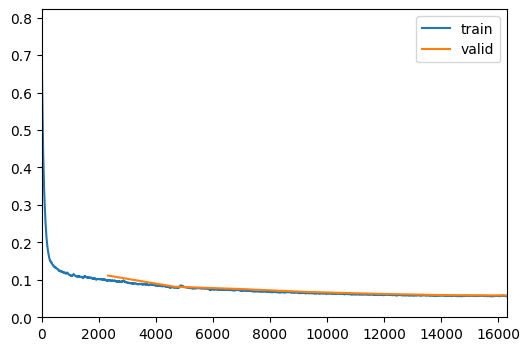

Better model found at epoch 1 with valid_loss value: 0.08154810965061188.
Better model found at epoch 2 with valid_loss value: 0.0754210576415062.
Better model found at epoch 3 with valid_loss value: 0.06758046895265579.
Better model found at epoch 4 with valid_loss value: 0.06293296068906784.
Better model found at epoch 5 with valid_loss value: 0.05930720269680023.
Better model found at epoch 6 with valid_loss value: 0.05840512365102768.


In [16]:
cbs = [SaveModelCallback(), ShowGraphCallback(), EarlyStoppingCallback(monitor='valid_loss', patience=3)]
n_epoch = 7

# Entrenar toda la red
learn.fit_one_cycle(n_epoch, cbs=cbs)

In [17]:
learn.save('/kaggle/working/fittingautoencodertotrain')

Path('/kaggle/working/fittingautoencodertotrain.pth')

### Cargando y validando el modelo

In [18]:
model_path = Path('/kaggle/input/encoder2/fittingautoencodertotrain')

# Cargar los pesos
learn.load(model_path)

In [19]:
# Realizar la validación
results = learn.validate(dl=valid_dl)
print("MAE:", results[1]) 

MAE: 0.05442299321293831


### Visualizando output del autoencoder

In [20]:
def visualizar_img(output: torch.Tensor, label: torch.Tensor, num: int):  
    nombres = ['Meningioma', 'Glioma', 'No Tumor']
    out_np = output.squeeze().numpy()
    label_np = label.squeeze().numpy()

    fig, axs = plt.subplots(1, 2)
    axs[0].imshow(out_np[2, :, :], cmap='gray') # Se 2 significa que se visualiza T2F
    axs[1].imshow(label_np[2, :, :], cmap='gray')
    
    plt.suptitle(f"Nº {num} {nombres[valid.iloc[num]['etiqueta']]}")
    plt.tight_layout()
    plt.show()

In [21]:
def visualizar_imgs():
    idx_ejemplos = random.sample(range(31900), 20)
    for i in idx_ejemplos:
        img_paths = valid.iloc[i][['ruta_t1c', 'ruta_t1n', 'ruta_t2f']].tolist()
        slice_num = valid.iloc[i]['slice']

        X = np.zeros((240, 240, 3))
        for idx, img_path in enumerate(img_paths): # Combinar cada slice de las 3 pruebas en 3 canales
                current_img = nib.load(img_path).dataobj[..., slice_num]
                X[:, :, idx] += standard_normalize(current_img)

        X = torch.from_numpy(X.T).type(torch.float32)
        X = X.unsqueeze(0)
        pred, target = learn.get_preds(dl=[(X, X)])
        visualizar_img(pred, target, i)

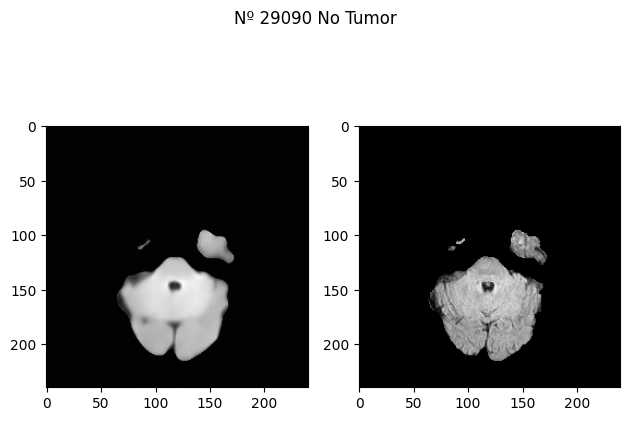

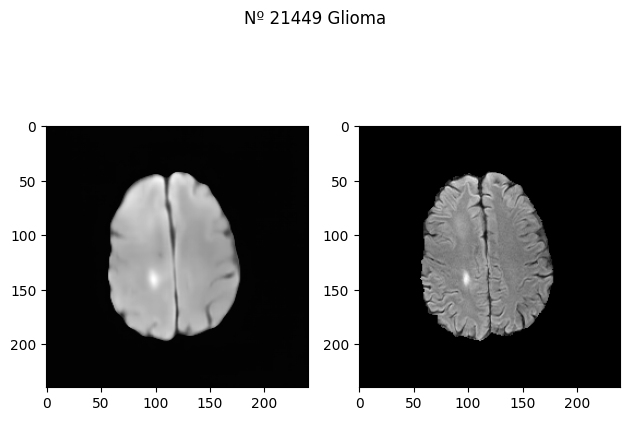

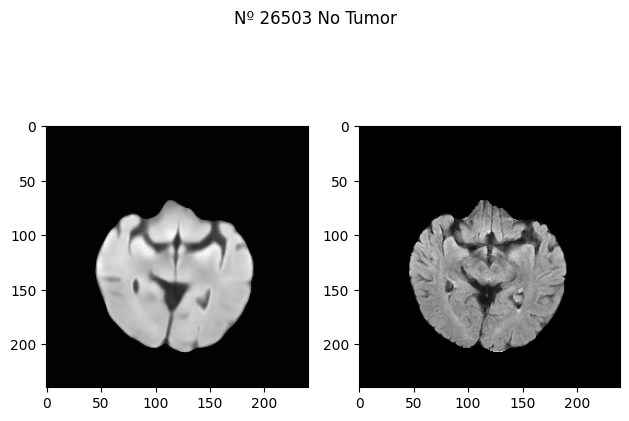

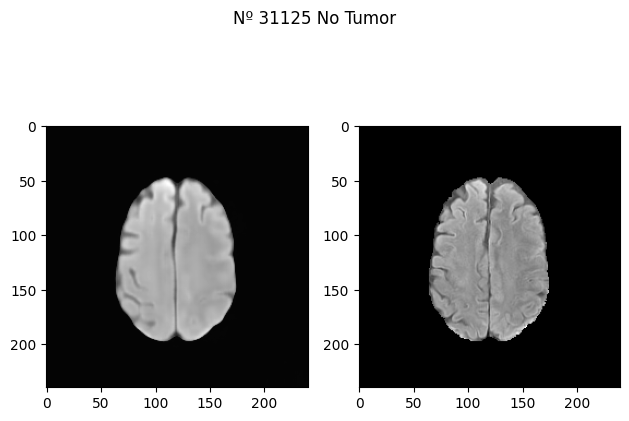

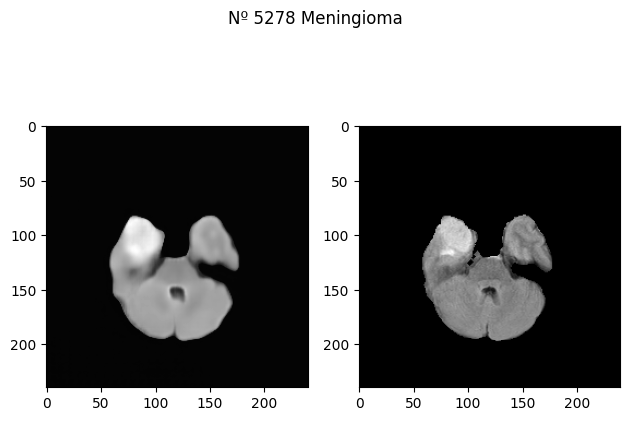

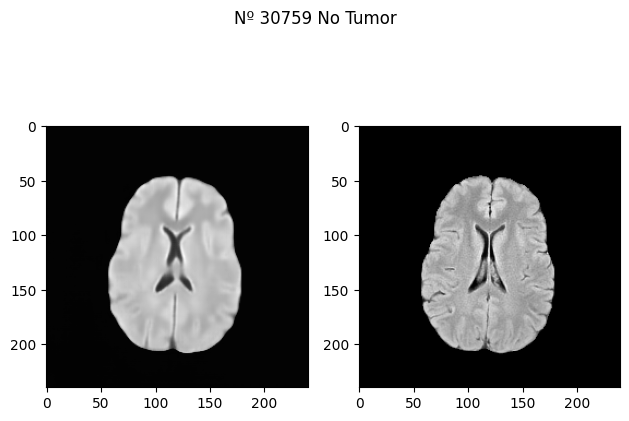

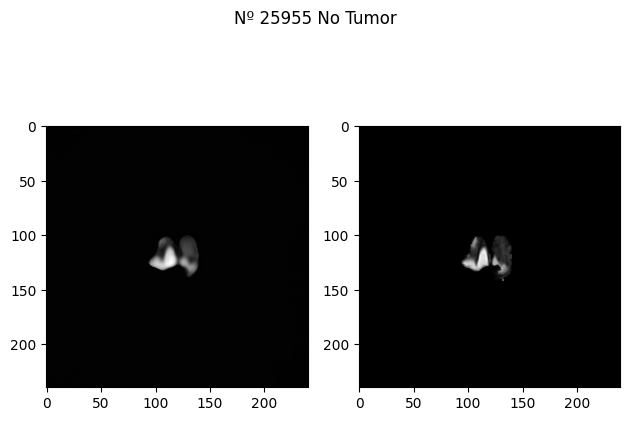

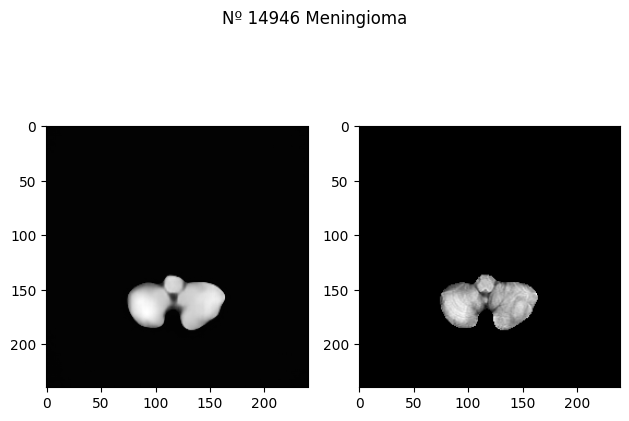

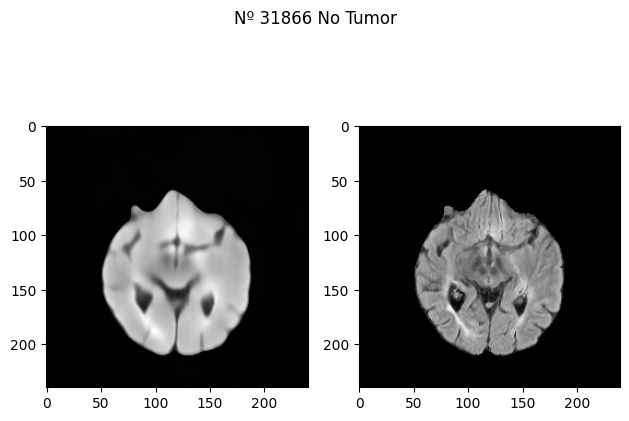

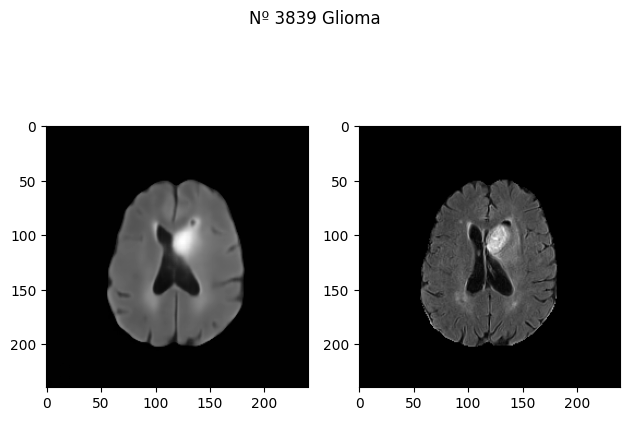

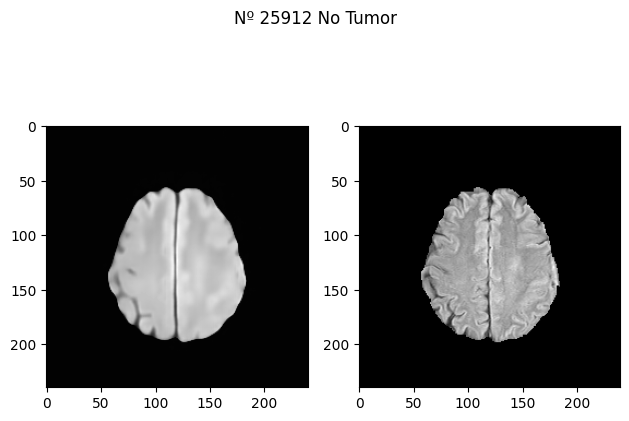

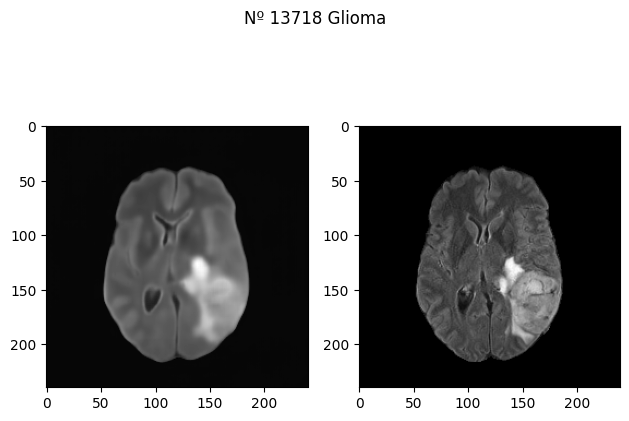

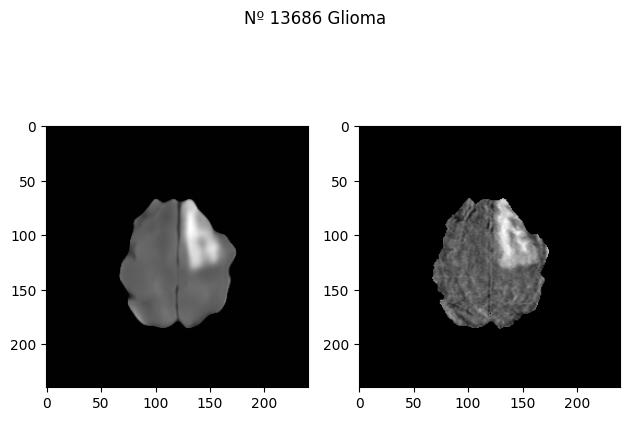

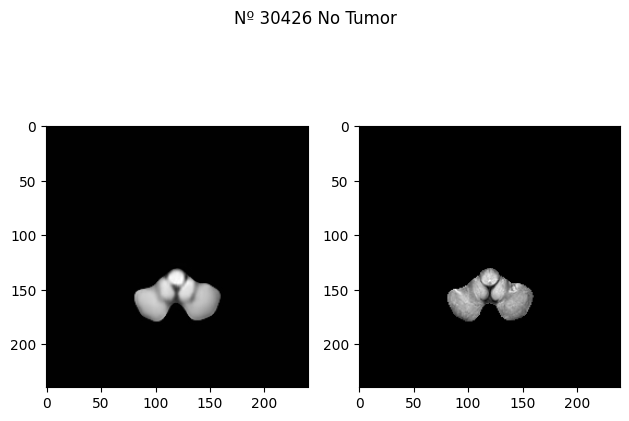

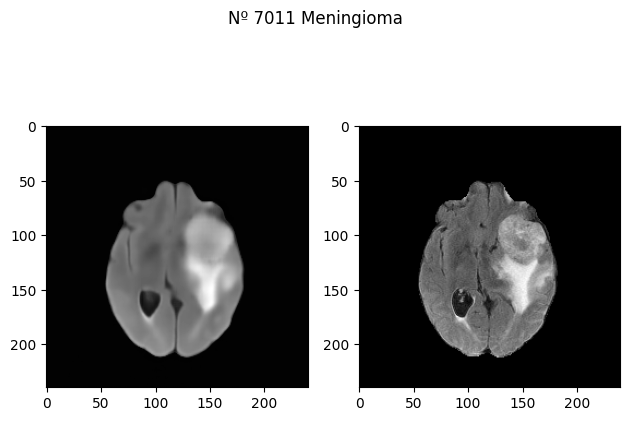

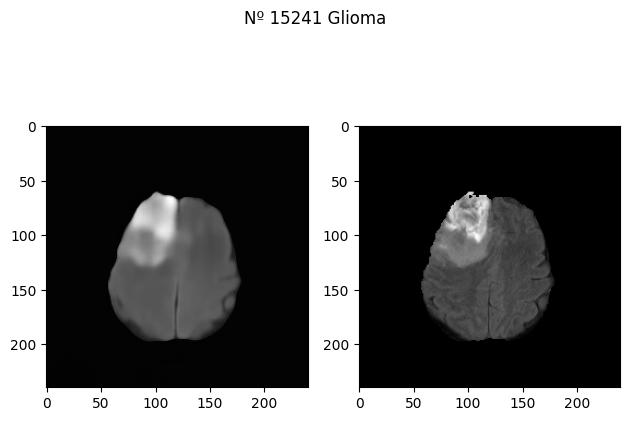

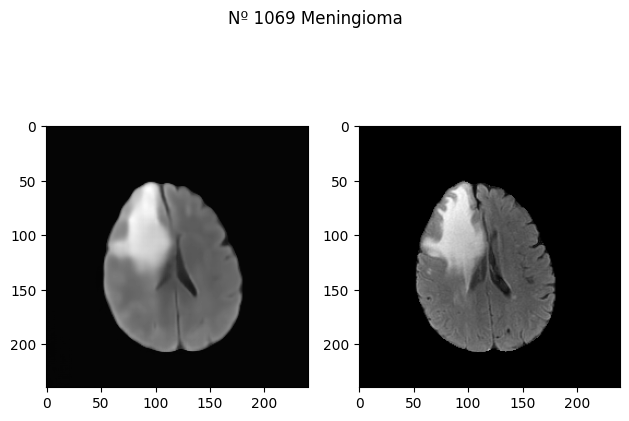

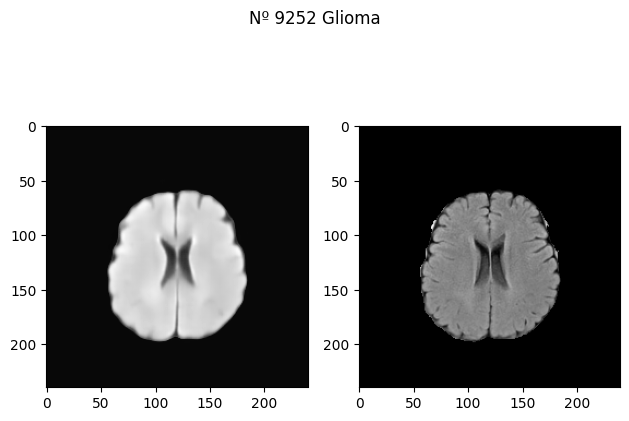

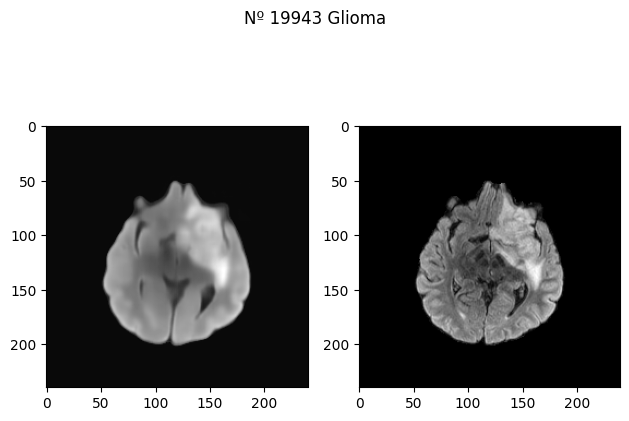

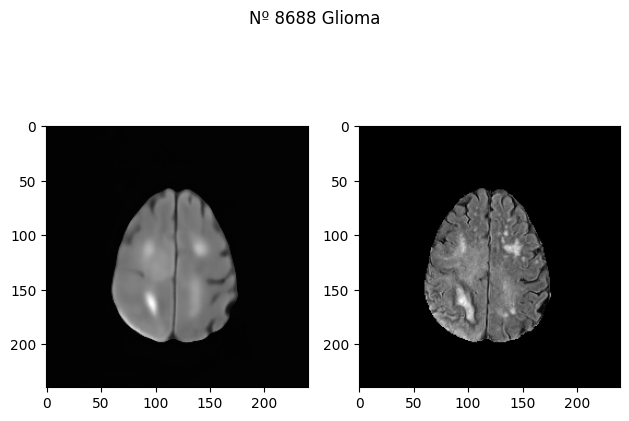

In [22]:
visualizar_imgs()